In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
import seaborn as sns
from IPython.display import clear_output

In [2]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [3]:
import sys
sys.path.append("../pyfiles/")
from util import image_from_output, cuda2numpy, class_encode, cuda2cpu, plot_correlation_matrix, corrcoef
from dataset import get_class_label, FaceDataset
from model import MinMax, SingleGenerator, SingleDiscriminator_solo_multi, Encoder_original
from util_notebook import SingleGAN_training, get_samples

# Introduction
---
In this notebook, we're going to explain the code to experiment with SingleGAN with a solo Discriminator proposed in StarGAN, focusing on the result of the models trained in `02-train_SingleGAN_soloD.ipynb`. The main purpose of this notebook is to check if a solo disciminator still works in proposed losses.


---

# CelebA Dataset
---
In this experiment, I'm gonna use the CelebA dataset, a face dataset that has plenty of annotations. We're therefore able to set various classes or conditions. I explained the details in `A_CelebA_dataset_usage.ipynb`.

---
### Preparation
---
First of all, navigate `root` to the root directory of the dataset and `label_root` to the directory of the label folder. `A_CelebA_dataset_usage.ipynb` also includes how the make the label folder.

---

In [4]:
###############################################
############ adjustable parameters ############

# root = "./../../dataset/celebA/img/"
# label_root = "./../../dataset/celebA/label_folder/"
root = "./../../research/sound_dataset/celebA/img_align_celeba_png/"
label_root = "./../../research/sound_dataset/celebA/label_folder/"

###############################################
###############################################

---
As I said, the CelebA dataset has plenty of annotations, so we need to define which annotation we're gonna use.
There are 3 ways to categorize the usage of the annotations.

- ***existed***: Get the images that belong to the selected annotations.
- ***delete***: Delete the images which belong to the selected annotations.
- ***class***: These annotations are used to compose the classes, \# of classes will be $2^{\#\_classes}$

In this experiment, I used some annotations owing to simplicity and 
set the classes by the use of annotations; "male", "smiling".

---

In [5]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [6]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

---
### Preprocessing
---
Firstly, The image in the dataset is center-cropped to be the shape (178, 178) and then resized to be the shape (128, 128). In the training process, the random horizontal flip is installed to augment the dataset. When it comes to the value of the image, it's normalized to a range of [-1, 1].


---

In [7]:
transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True)
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True)
])

---
Let's have a look at some samples of the dataset.

---

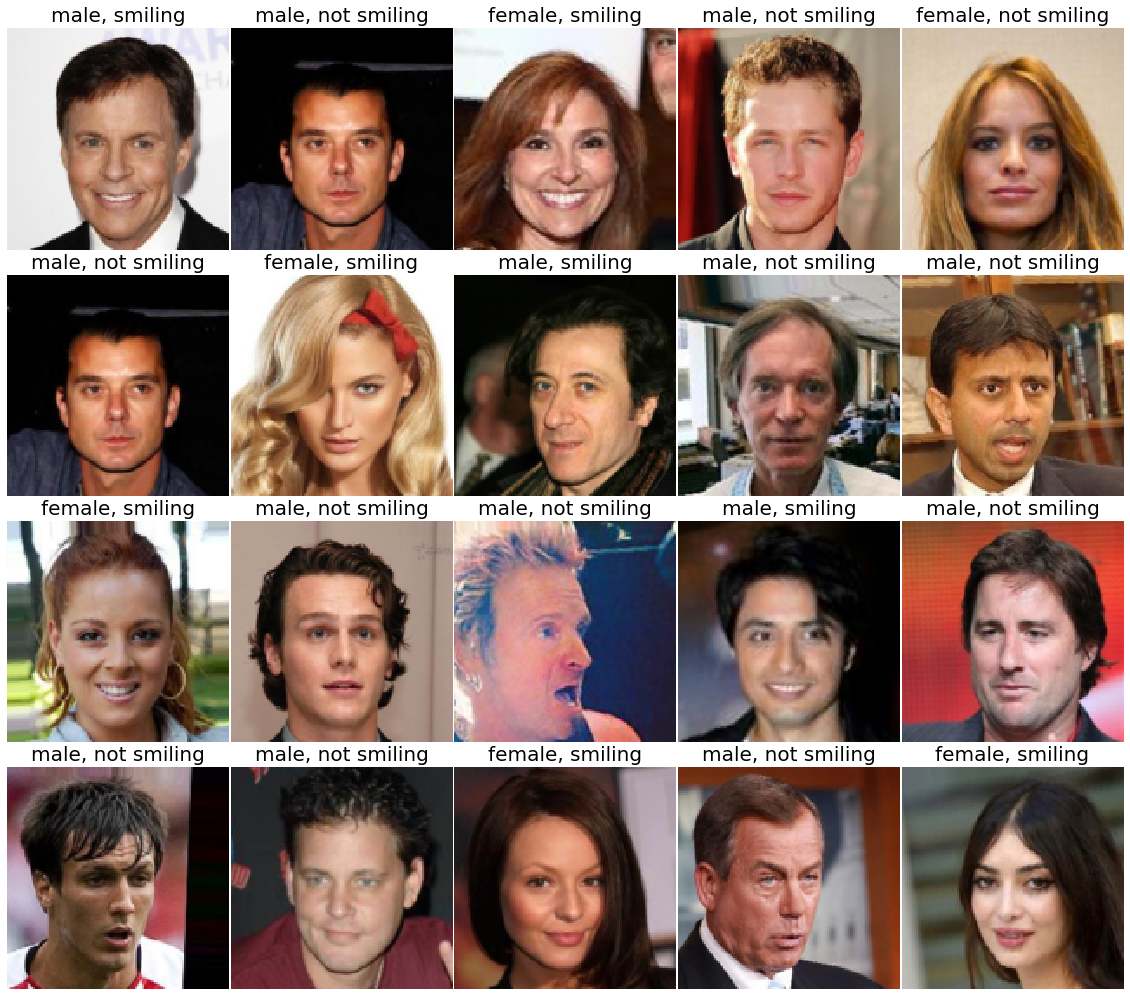

In [8]:
width = 5
length = 4
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=10000, val_num=0, test_num=100)
fig = plt.figure(figsize=(4*width, 4.5*length))
for i in range(width*length):
    ax = fig.add_subplot(length, width, i+1)
    index = np.random.randint(0,len(dataset))
    data = dataset[index]
    img = data[0]
    image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
    ax.imshow(image)
    ax.set_title(label_discription[data[1]], fontsize=20)
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

# Results
---
Let's examine the model.

---
### Preparation
---
At first, let's define some parameters for the architecture of the models, including a generator, a discriminator, and an encoder.

---

In [9]:
ndim = 8 # dimension of the latent code for style
nch_in = 3 # the number of channels for input images 

# Hyper-parameters for a generator
nch = 64 # the number of channels for the first convolutional layer
reduce = 2 # image's shape is reduced by a factor of this value
num_cls = 2 # the number of convolutional blocks for compression and expansion
res_num = 6 # the number of residual blocks

# Hyper-parameters for a generator
dis_reduce = 2 # image's shape is reduced by a factor of this value
dis_nch = 64 # the number of channels for the first convolutional layer
dis_num_cls = 4 # the number of convolutional blocks for compression
save_parameter = True # save parameters for the models or not
criterion = nn.MSELoss() # evaluation metrics for discriminator's output
criterion_class = nn.MSELoss() # evaluation metrics for discriminator's output (classification)
ref_label = np.eye(len(classes)) # class label: one-hot label is employed

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

---
Next, define more detailed information for the models and the lambda parameters for training.
In this experiment, we're just going to check the possibility of the employment of a solo discriminator so there is no parameter to adjust.

---

In [11]:
restriction_type = "proposedKL" # "conventionalKL" or "proposedKL": employed losses for restriction of the encoder's distribution
if restriction_type == "conventionalKL":
    encoded_feature = "latent" # "latent" or "mu": the encoded features used for regression loss
elif restriction_type == "proposedKL":
    encoded_feature = "mu" # "latent" or "mu": the encoded features used for regression loss

lbd = {}
lbd["cycle"] = 5 # cycle consistency loss
lbd["idt"] = 5 # identity loss
lbd["reg"] = 0.5 # conventional regression loss
lbd["idt_reg"] = 0.5 # regression loss for indentity images
    
if restriction_type == "conventionalKL":
    lbd["KL"] = 0.1 # conventional KL divergence loss
    lbd["batch_KL"] = 0 # batch KL dvergence loss
    lbd["corr_enc"] = 0 # correlation loss
    lbd["hist"] = 0 # histogram imitation loss
elif restriction_type == "proposedKL":
    lbd["KL"] = 0 # conventional KL divergence loss
    lbd["batch_KL"] = 10 # batch KL dvergence loss
    lbd["corr_enc"] = 100 # correlation loss
    lbd["hist"] = 100 # histogram imitation loss
    
unrolled_k = 5 # k for UnrolledGAN

---
Then, let's call the selected models and load the parameters(weights).

---

In [12]:
# call the selected models
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netD = SingleDiscriminator_solo_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance", ref_label.shape[1]).to(device)
netE = Encoder_original(nch_in, ndim, nch, 4, "instance", ref_label.shape[1], device).to(device)
sg = SingleGAN_training([netG, netD, netE], [None, None, None], [criterion, criterion_class], 
                       lbd, unrolled_k, device, ref_label, ndim, classes, None, encoded_feature, True)
sg.opt_sche_initialization()

# load parameters for the generator and the encoder
dir = "./../data/parameters/02/"
gen_path = dir + f"gen_singleD_SingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch30.pth"
enc_path = dir + f"enc_singleD_SingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_idtreg{lbd['idt_reg']}_bKL{lbd['batch_KL']}_correnc{lbd['corr_enc']}_hist{lbd['hist']}_unrolledk{unrolled_k}_epoch30.pth"
gen_model = torch.load(gen_path, map_location=device)
enc_model = torch.load(enc_path, map_location=device)
netG.load_state_dict(gen_model)
netE.load_state_dict(enc_model)

<All keys matched successfully>

---
call test dataset, which is certainly separated from training dataset.

---

In [13]:
num = 100
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=10000, val_num=0, test_num=100)

---
run the code below to get data from the test dataset

- `samples`: source images of the dataset
- `labels`: domain codes for the source images
- `mu_list`: encoded features for the source images
- `latent`: latent code for generating target images

---

In [15]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=128, shuffle=False)
for itr, data in enumerate(dataloader):
    netE.eval()
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    class_vector = class_encode(data_label, device, sg.ref_label)
    _, mu, _, = netE(data_image, class_vector)
    if itr==0:
        mu_list = cuda2cpu(mu)
        labels = cuda2cpu(data_label)
        samples = cuda2cpu(data_image)
    else:
        mu_list = np.concatenate([mu_list, cuda2cpu(mu)], axis=0)
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)
latent = np.random.randn(num, ndim)

---
Not every image in the test dataset has been translated successfully into the target domain. The examples below are the index of the data which is, at least, well-transformed in our environment and the title indicates the index.

---

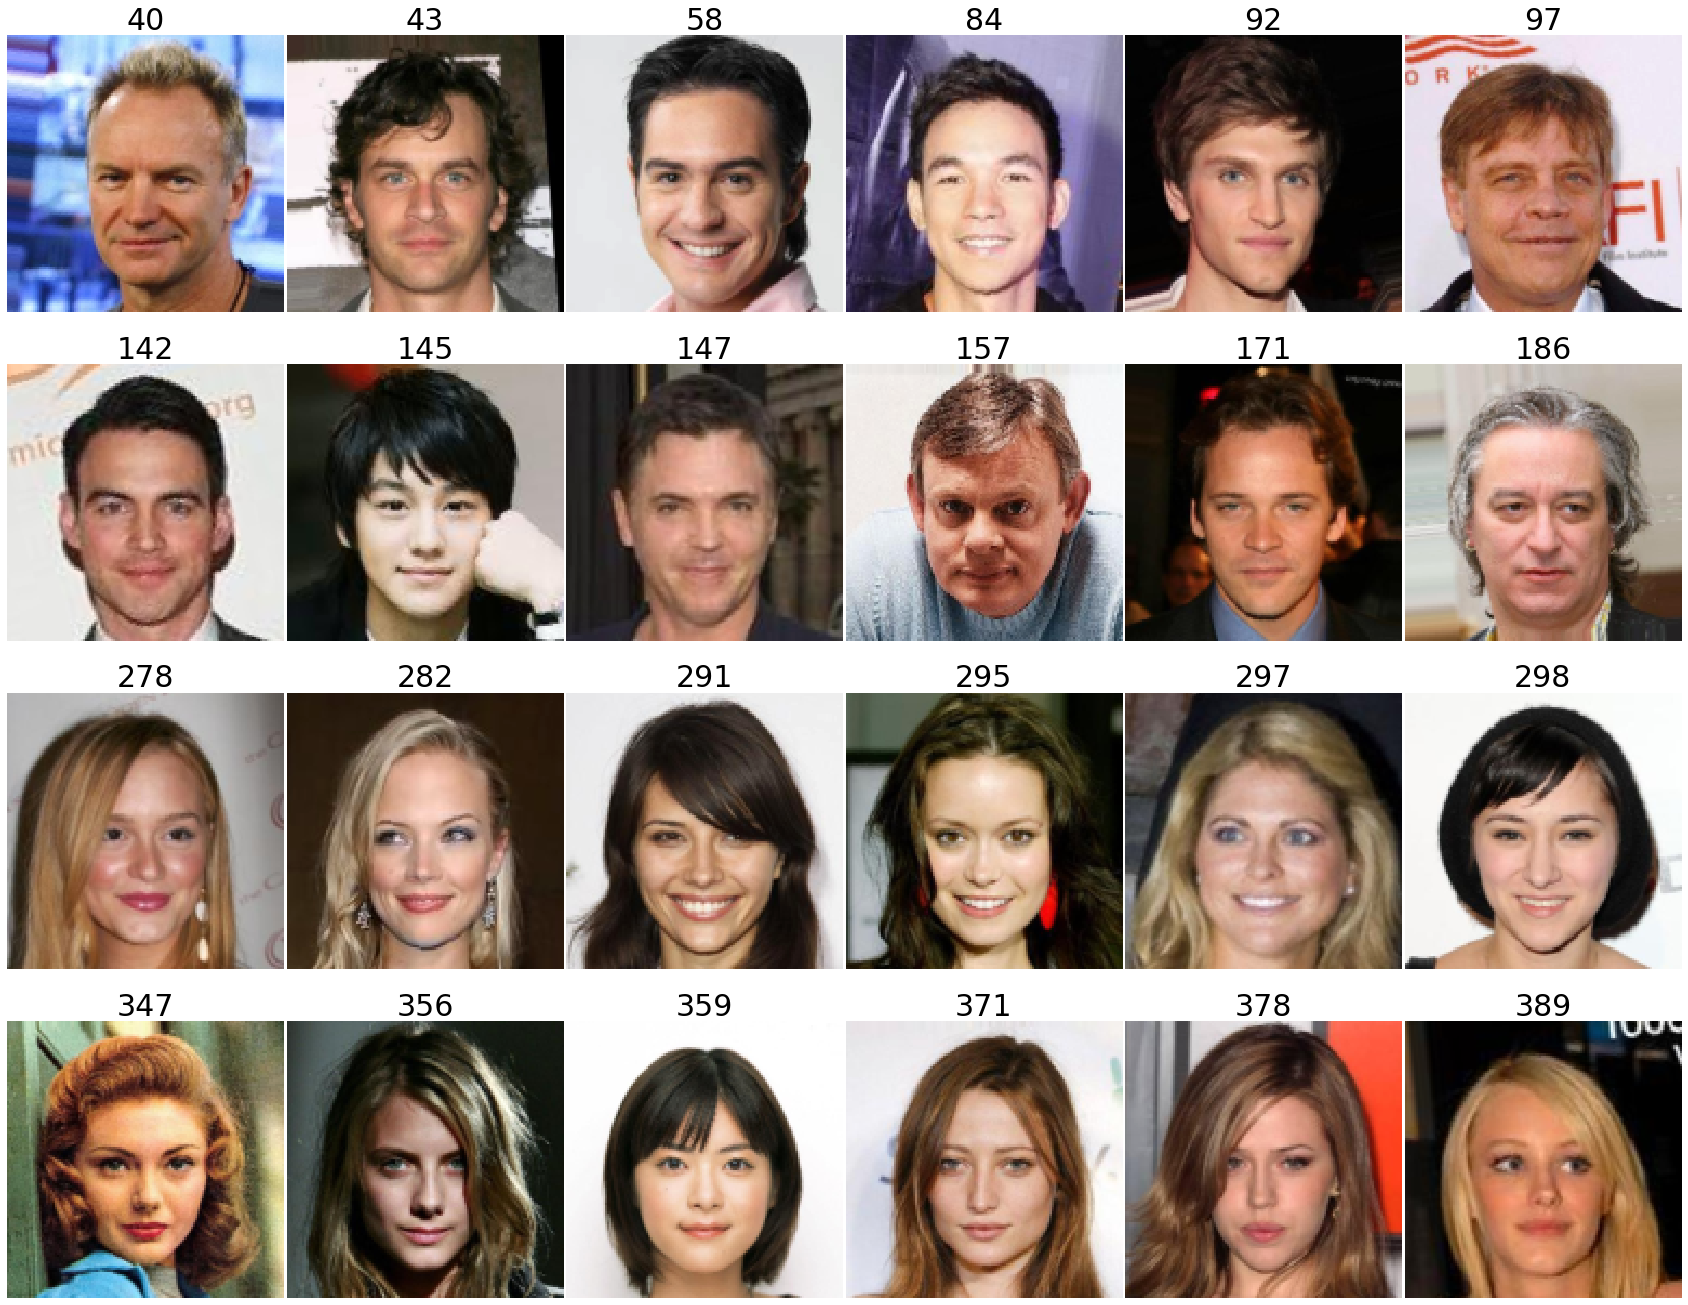

In [16]:
index_list = {}
index_list[0] = [num*1-3, num*1-8, num*1-16, num*1-42, num*1-57, num*1-60]
index_list[1] = [num*2-14, num*2-29, num*2-43, num*2-53, num*2-55, num*2-58]
index_list[2] = [num*3-2, num*3-3, num*3-5, num*3-9, num*3-18, num*3-22]
index_list[3] = [num*4-11, num*4-22, num*4-29, num*4-41, num*4-44, num*4-53]
for i in classes:
    index_list[i].sort()
    
length = len(classes)
width = len(index_list[0])

fig = plt.figure(figsize=(5*width, 6*length))

for i in range(length):
    for j in range(width):
        ax = fig.add_subplot(length, width, i*width+j+1)
        index = index_list[i][j]
        image = testset[index][0]
        image = image_from_output(image.unsqueeze(0))[0]
        ax.imshow(image)
        ax.set_title(index, fontsize=30)
        plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

### Generator's output
---
Let's observe the main part of this model, which is the output of the generator. You can change the value of the index to see different results.

---

In [17]:
###############################################
############ adjustable parameters ############

idx = 389 # index of the test dataset

###############################################
###############################################
data, label = get_samples(netG, netE, testset, idx, latent, classes, ref_label, ndim, image_type="pil", batch=32, device=device, conventional_E=True)

---
This is the output of translation to each class with different style vectors shown vertically.

---

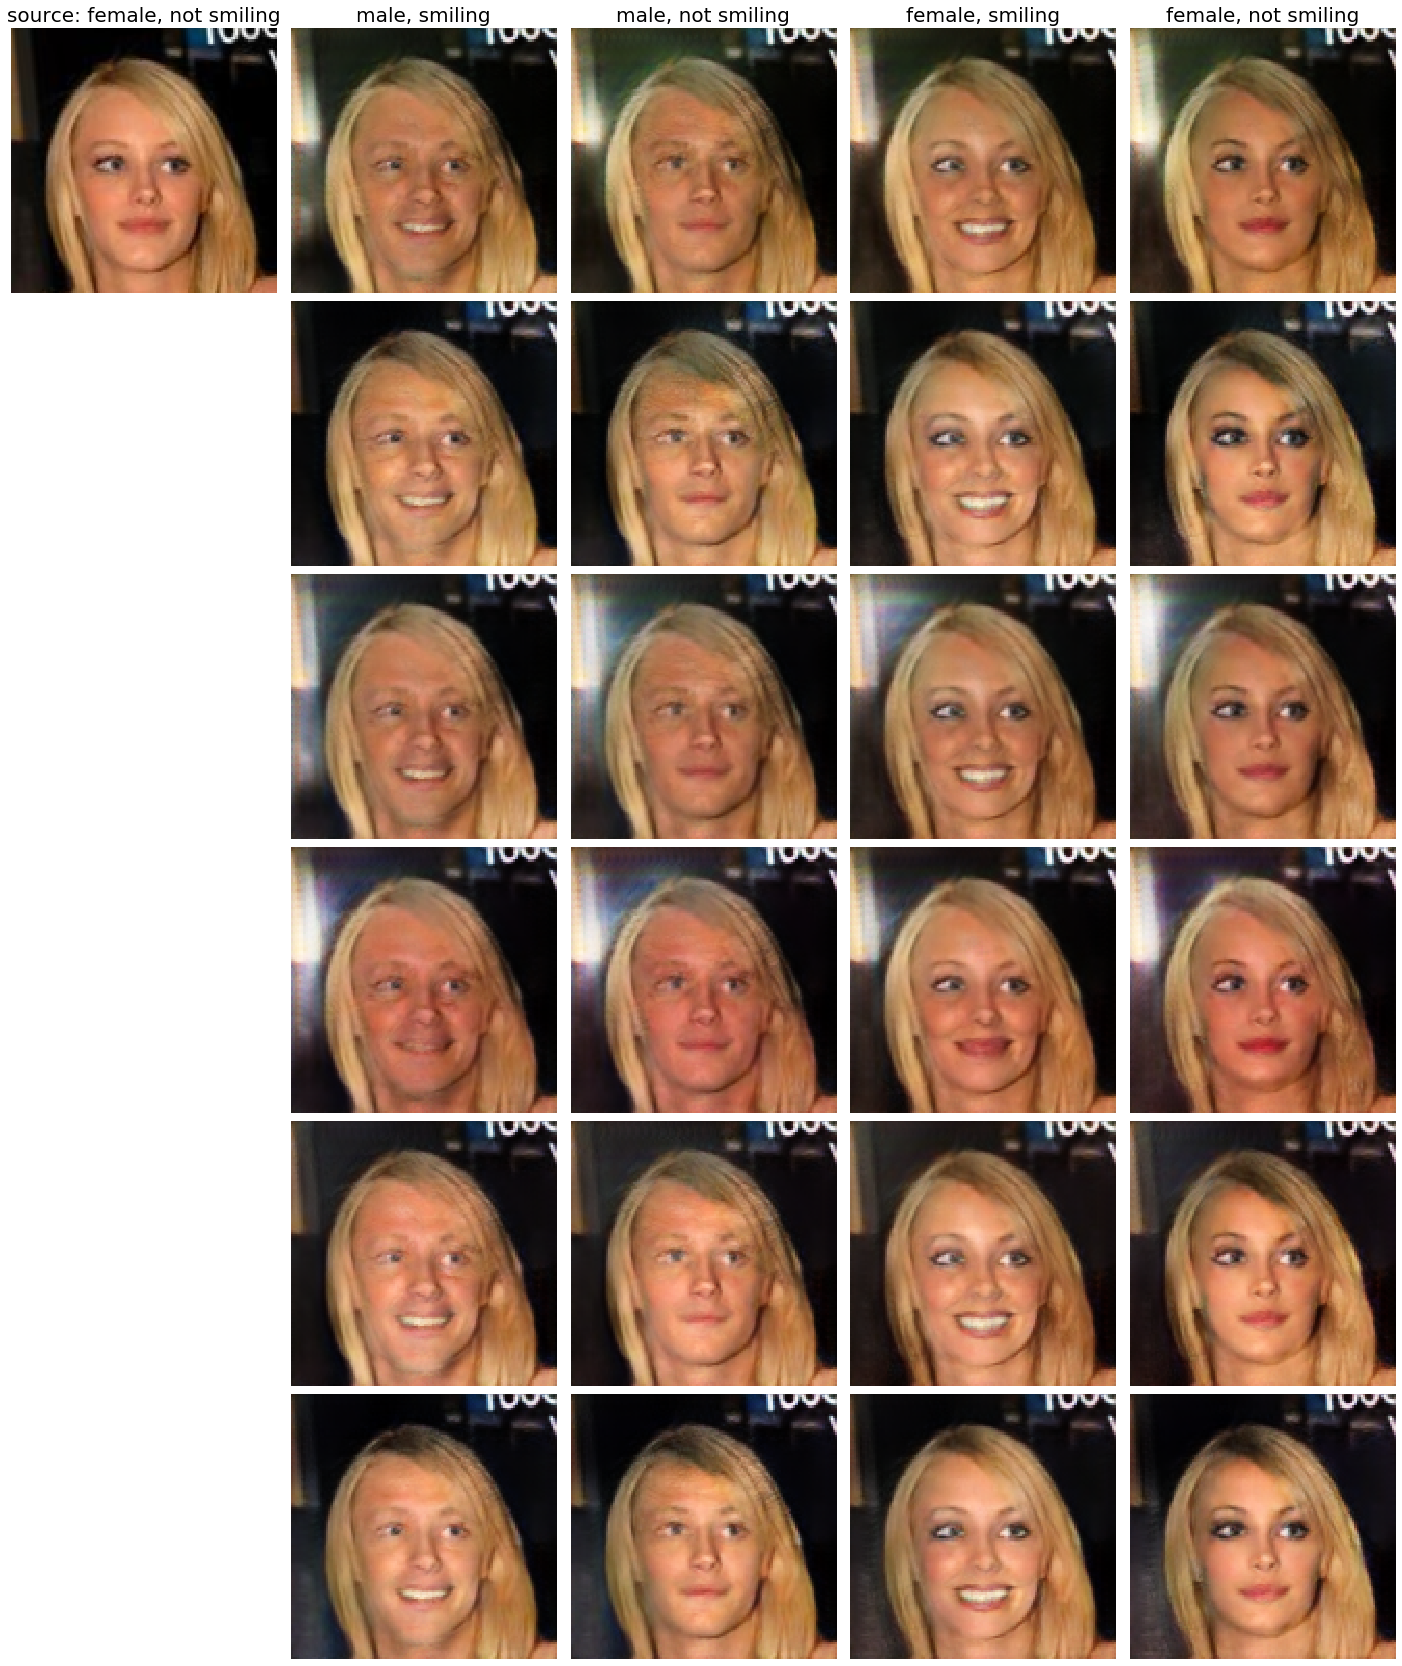

In [18]:
length = 6
images = data["target"]

width = len(classes)+1
fig = plt.figure(figsize=(5*width, 5*length))
np.random.seed(1)
a = np.random.choice(np.arange(num), length, False)
index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title(f"source: {label_discription[testset[idx][1]]}", fontsize=20)
plt.axis('off')

for i in range(length):
    for j in classes:
        index = i*(len(classes)+1)+j+2
        ax = fig.add_subplot(length, width, index)
        ax.imshow(images[j][a[i]])
        if i == 0:
            ax.set_title(label_discription[j], fontsize=20)
        plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

---
Next, these are the outputs of a certain class with different latent codes (style vectors).

- `target_label`: target class

---

female, smiling


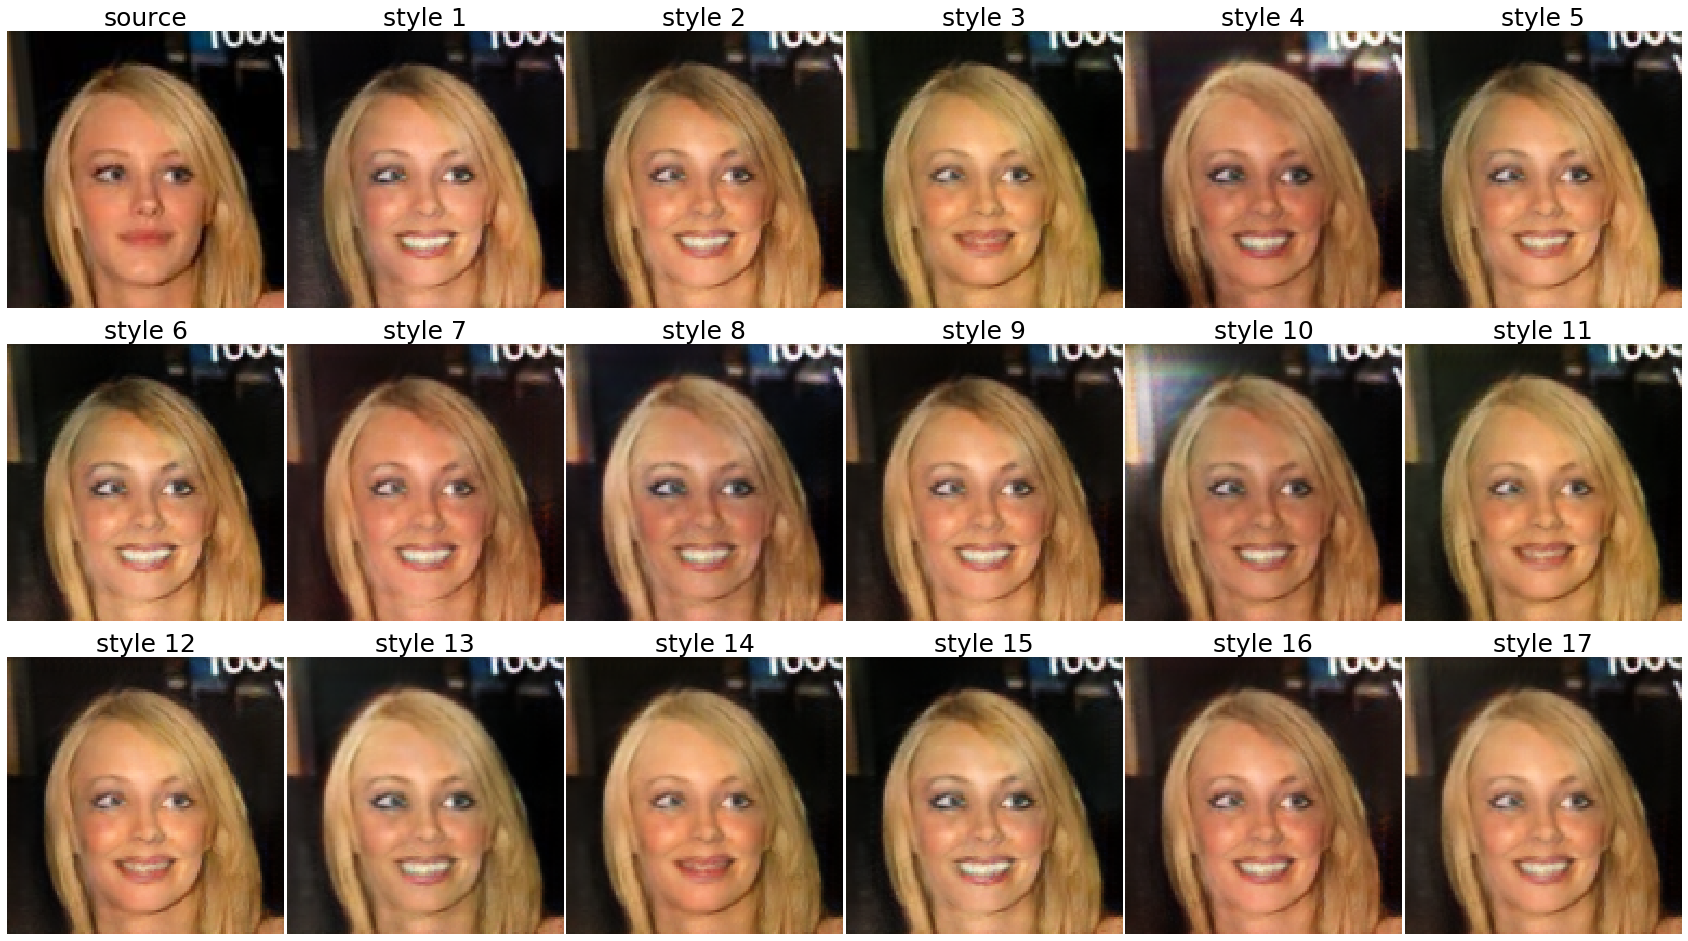

In [19]:
###############################################
############ adjustable parameters ############

target_label = 2 # target class

###############################################
###############################################

length = 3
width = 6
images = data["target"][target_label]
np.random.seed(8)
a = np.random.choice(np.arange(num), length*width, False)
fig = plt.figure(figsize=(5*width, 5.7*length))
print(label_discription[target_label])

index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source", fontsize=25)
plt.axis('off')

for i in range(length*width-1):
    index = i+2
    ax = fig.add_subplot(length, width, index)
    ax.imshow(images[a[i]])
    ax.set_title(f"style {i+1}", fontsize=25, )
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

### Encoder's output
---
In this section, we're going to look at the output of the encoder.

---
#### Distribution
---
Firstly, the distribution of the encoded features is compared with Gaussian distribution. <font color=blue>the blue circle</font> indicates the desired distribution with the same data size as the encoded features and <font color=orange>the orange cross</font> is the encoded features. 

---

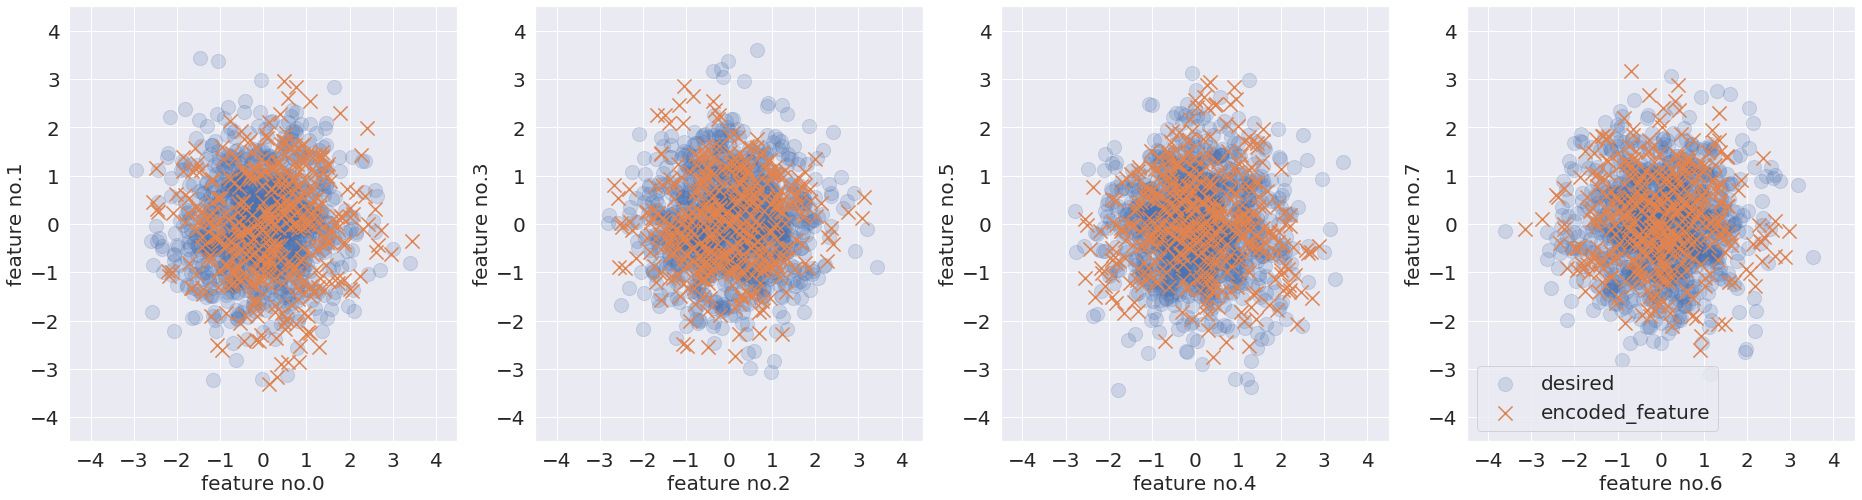

In [20]:
length = 1
width = 4

sns.set()
a = torch.randn(1000, 8)
b = torch.tensor(mu_list)

fig = plt.figure(figsize=(8*width, 8*length))
for i in range(length*width):
    ax = fig.add_subplot(length, width, i+1)
    ax.scatter(a[:,2*i], a[:,2*i+1], alpha=0.2, label="desired", marker="o", s=200)
    ax.scatter(b[:,2*i], b[:,2*i+1], label="encoded_feature", marker="x", s=200)
    ax.set_xlabel(f"feature no.{2*i}", fontsize=20)
    ax.set_ylabel(f"feature no.{2*i+1}", fontsize=20)
    if i == 3:
        plt.legend(fontsize=20)
    plt.xlim(-4.5, 4.5)
    plt.ylim(-4.5, 4.5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
sns.reset_orig()

---
Then, 3D-visualization. You can control it interactively.

- `feature_dimension_idx`: the index used to visualize the distribution, its length should be 3.

---

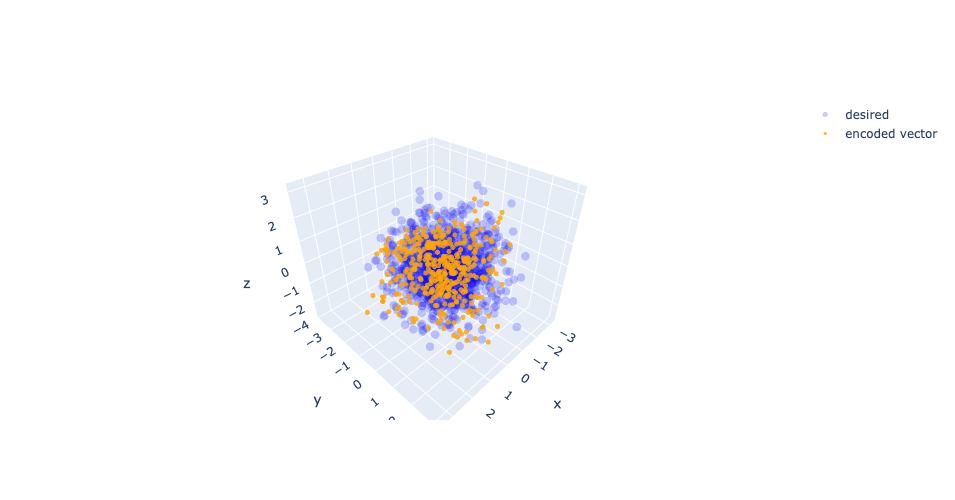

In [21]:
###############################################
############ adjustable parameters ############

feature_dimension_idx = [0, 1, 2] # the index used to visualize the distribution, its length should be 3

###############################################
###############################################

trace = []
m = np.random.randn(1000, 3)
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"desired", 
                          marker = dict(size=5, opacity=0.2, color="blue")))

m = mu_list[:,feature_dimension_idx]
_x = m[:, 0] 
_y = m[:, 1]
_z = m[:, 2]
trace.append(go.Scatter3d(x=_x, y=_y, z=_z, mode="markers", name=f"encoded vector", 
                          marker = dict(size=3, opacity=0.8, color="orange")))


layout = go.Layout(width=500, height=500)    
data = trace
fig = dict(data=data, layout=layout)
iplot(fig)

---
#### Correlation Matrix
---

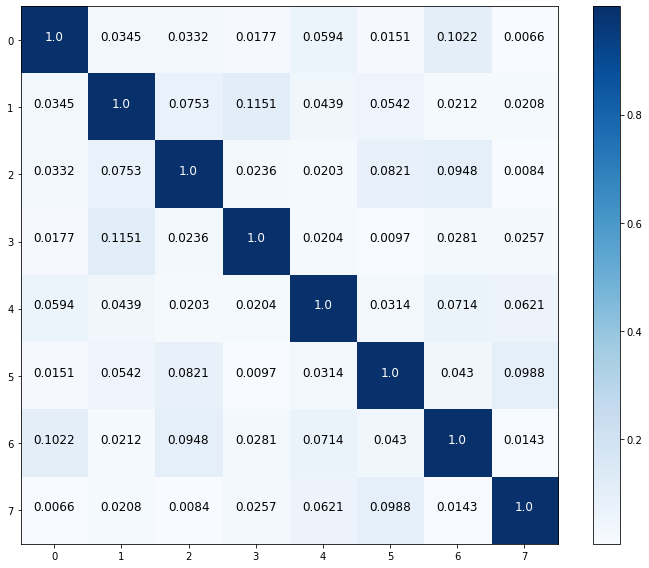

In [22]:
plot_correlation_matrix(np.abs(np.array(corrcoef(torch.tensor(mu_list.T)))), False, "", "")

---
#### Histogram
---

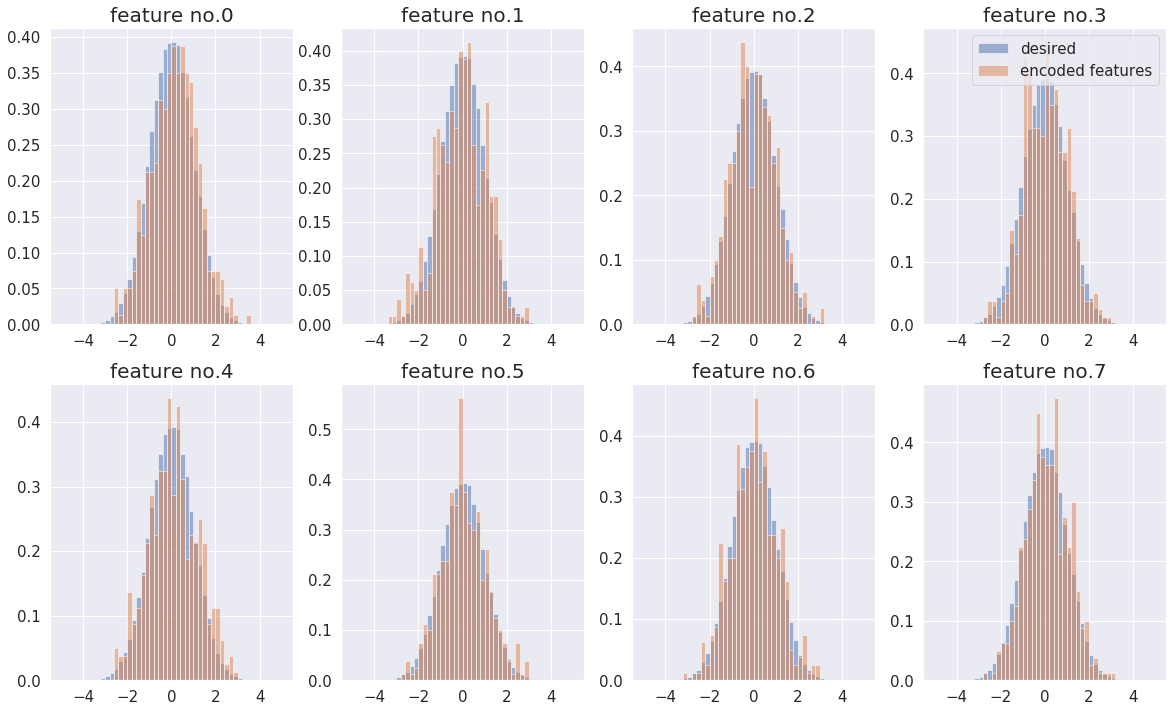

In [23]:
length = 2
width = 4

a = torch.randn(100000, 1)
b = torch.tensor(mu_list)
sns.set()

range_max = 5
bins = 50

fig = plt.figure(figsize=(5*width, 6*length))
for i in range(length*width):
    ax = fig.add_subplot(length, width, i+1)
    ax.hist(cuda2numpy(a[:,0]), bins=bins, range=(-range_max, range_max), density=True, alpha=0.5, label="desired")
    ax.hist(cuda2numpy(b[:,i]), bins=bins, range=(-range_max, range_max), density=True, alpha=0.5, label="encoded features")
    if i ==3:
        plt.legend(fontsize=15)
    ax.set_title(f"feature no.{i}", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
sns.reset_orig()

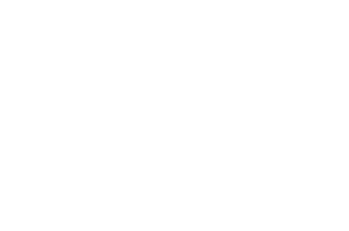

In [26]:
###############################################
############ adjustable parameters ############

save = True

###############################################
###############################################

if save:
    from util import save_gif
    gif_dir = f"../data/results/02/"
    for idx in [142, 145, 359, 389]:
        data, label = get_samples(netG, netE, testset, idx, latent, classes, ref_label, ndim, image_type="pil", batch=32, device=device, conventional_E=True)
        for cl in [0, 2]:
            gif_path = f"{gif_dir}SingleGAN_soloD_{idx}_class{cl}.gif"
            save_gif(data["target"][cl][:50], gif_path, label_discription[cl], duration=250)

### Quantitative Results
---
As mentioned in the paper, the results include quantitative evaluation as well as a qualitative one. In this paper, we employ Precision and Density for fidelity; and Recall and Coverage for diversity.

---
#### Preparation
---
This is the preparation for evaluation. Let's define a new variable and get the variables previously mentioned.

- `fe_list`: the name list for feature extractors
- `samples`: source images of the dataset
- `labels`: domain codes for the source images

---

In [33]:
from evaluation import GAN_evaluation, evaluation_init

In [34]:
fe_list = ["vgg-initialization", 
           "vgg-ImageNet", 
           "vgg-CelebA"]

In [35]:
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=10000, val_num=0, test_num=1000)
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=1000, shuffle=False)

for itr, data in enumerate(dataloader):
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    if itr==0:
        labels = cuda2cpu(data_label)
        samples = cuda2cpu(data_image)
    else:
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)

---
#### Result with a single example 
---
Initially, let us show a single result of the selected index.



---

In [37]:
###############################################
############ adjustable parameters ############

index = 142 # index for test dataset

###############################################
###############################################

latent = np.random.randn(len(testset), ndim)
data, label = get_samples(netG, netE, testset, index, latent, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=True)

In [38]:
fe = fe_list[0]
print(fe)
print("")
ge = GAN_evaluation(fe, device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

vgg-initialization

Num real: 1000 Num fake: 4000


{'precision': 0.99175, 'recall': 0.0, 'density': 1.1998, 'coverage': 0.072}

In [39]:
fe = fe_list[1]
print(fe)
print("")
ge = GAN_evaluation(fe, device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

vgg-ImageNet

Num real: 1000 Num fake: 4000


{'precision': 0.93625,
 'recall': 0.0,
 'density': 1.9258500000000003,
 'coverage': 0.103}

In [40]:
fe = fe_list[2]
print(fe)
print("")
ge = GAN_evaluation(fe, device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

vgg-CelebA

Num real: 1000 Num fake: 4000


{'precision': 1.0, 'recall': 0.126, 'density': 1.1142, 'coverage': 0.225}

---
#### Result with multiple examples
---
Two cells below indicate the result of multiple examples and the code to save it. It takes time when you set `sample_num` as a high value (100 samples take around 8 hours). After saving the results, we'll be able to compare this result with others' in `06_Comparison_PRDC.ipynb`.

- `sample_num`: the number of examples for the evaluation
- `save`: save the result or not
- `save_path`: the path where you save the result

---

In [ ]:
###############################################
############ adjustable parameters ############

sample_num = 100
save = False
save_path = f"../data/results/02/02_GAN_evaluation_singleD.pkl"

###############################################
###############################################

init = True
if init:
    GAN_eval = evaluation_init(fe_list, classes, metrics)
    start = 0
else:
    start = len(GAN_eval[fe_list[0]][0][0]["coverage"])
    
for i in range(sample_num):
    clear_output(wait=True)
    print(i)
    for source_label in classes:
        index = source_label*num + (start+i)
        data, label = get_samples(netG, netE, testset, index, latent, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=True)
        for target_label in classes:
            for fe in fe_list:
                ge = GAN_evaluation(fe, device, classes, [target_label])
                metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
                for metric in metrics.keys():
                    GAN_eval[fe][source_label][target_label][metric].append(metrics[metric])

if save:
    pickle_save(GAN_eval, save_path)